#                                                 DATA ANALYSIS

# STEP 1. Problem statement

I have data with the actions of online course users from 2015 to 2018. The goal is to train a model that can predict users' future success on the first two days of the course with high accuracy. So, to train it, we need to collect the right features and information about whether the user finished the last lesson of the course or not. Then use test data - user actions from 2018 to 2019 and evaluate the accuracy of the resulting model.

# STEP 2. Load data and import libraries

In [1]:
import pandas as pd 
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
event_data = pd.read_csv(r"event_data_train.csv")
submission_data = pd.read_csv(r"submissions_data_train.csv")
event_data

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [3]:
submission_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


# STEP 3. See the possible values for all nominal variables

In [4]:
event_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [5]:
submission_data.submission_status.unique()

array(['correct', 'wrong'], dtype=object)

# STEP 4. Look at the data

4.1 Type of variables.

In [6]:
submission_data.dtypes

step_id               int64
timestamp             int64
submission_status    object
user_id               int64
dtype: object

In [7]:
event_data.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

Now we can conclude that numeric values have the int64 data type, which simplifies working with them. Some columns have data type object, it is worth to pay attention to it

4.2 Data size

In [8]:
submission_data.shape

(509104, 4)

In [9]:
event_data.shape

(3480703, 4)

The dataset event_data is noticeably larger than submission_data. This is easy to explain, because any user action is added to event_data, while submission_data contains only attempts to complete the task

4.3 Data describes.

In [10]:
submission_data.describe()

,step_id,timestamp,user_id
count,509104.000000,5.091040e+05,509104.000000
mean,33732.591433,1.480582e+09,13198.874945
std,9379.377465,3.097267e+07,7820.240678
min,31971.000000,1.434341e+09,2.000000
25%,32031.000000,1.449950e+09,6431.000000
50%,32763.000000,1.484339e+09,13082.000000
75%,33481.000000,1.508326e+09,19985.000000
max,120745.000000,1.526771e+09,26798.000000


In [11]:
event_data.describe()

,step_id,timestamp,user_id
count,3.480703e+06,3.480703e+06,3.480703e+06
mean,3.487358e+04,1.480288e+09,1.331468e+04
std,1.422243e+04,3.068906e+07,7.779099e+03
min,3.045600e+04,1.434341e+09,1.000000e+00
25%,3.217900e+04,1.450271e+09,6.642000e+03
50%,3.292900e+04,1.483904e+09,1.320800e+04
75%,3.348100e+04,1.507889e+09,2.014400e+04
max,1.584330e+05,1.526773e+09,2.679800e+04


The description does not give any information because in this case the numeric variables are not quantitative variables

4.4 Checking empty values

In [12]:
event_data.isnull().sum()

step_id      0
timestamp    0
action       0
user_id      0
dtype: int64

In [13]:
submission_data.isnull().sum()

step_id              0
timestamp            0
submission_status    0
user_id              0
dtype: int64

In this case, all the data are filled in, which means applying gap-filling options such as using mean values or using additional machine learning models to predict missing values will not be necessary.

# STEP 5. Visualisation

In this case only timestamps can be an interesting numerical quantity; let's construct a histogram of the time distribution and verify that most of the actions were performed when the course was opened.

<Axes: >

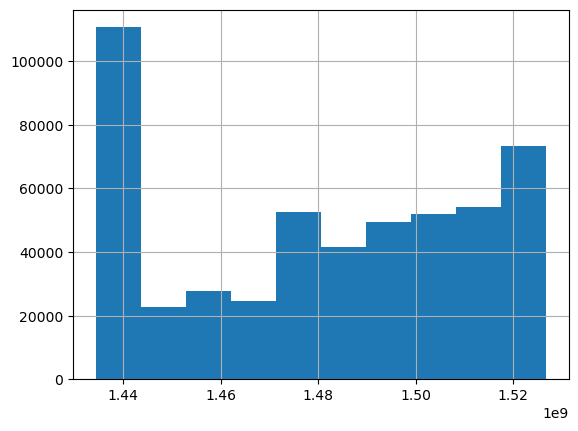

In [14]:
submission_data.timestamp.hist()

<Axes: >

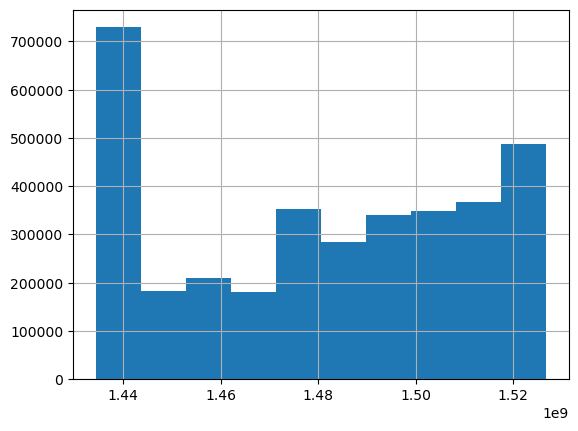

In [15]:
event_data.timestamp.hist()

From these histograms we can conclude that the interest in the course was maximum in the first months of its existence, but after a sharp drop relative to the first time, the interest in the course slowly increased

# STEP 6. Data grouping

6.1 See how many entries there were for the different action categories

In [18]:
event_data.groupby('action').count()

,step_id,timestamp,user_id
action,,,
discovered,689495,689495,689495
passed,650331,650331,650331
started_attempt,310047,310047,310047
viewed,1830830,1830830,1830830


We notice that people view the task most of all, and make fewer attempts to start solving the task. It can be seen that the number of passed tasks is more than twice the number of started_attempt. An explanation is needed here. This course was posted on stepic.org. On this site all courses are divided into steps. These can be tasks, video lectures and theoretical reference. Each step studied is counted as passed, while started_attempt is valid only for tasks.

6.2 Now let's see how the incorrect and correct attempts are distributed.

In [19]:
submission_data.groupby('submission_status').count()

,step_id,timestamp,user_id
submission_status,,,
correct,222705,222705,222705
wrong,286399,286399,286399


Now let's see how the incorrect and correct attempts are distributed. Surprisingly, the number is mostly the same. This indicates the "difficulty" of the course as a whole. Each task is solved on average by a user in two attempts. However, it should be noted that one user can complete the step several times if he/she decides to optimize his/her answer.

# STEP 7. Data correctness check

7.1 In this case, how to check the correctness of the data? In the first dataset we have user actions on the site. It would be logical to see how "real" these labels seem to be. For example, one user is unlikely to click "started_attempt" in several tasks at the same time. Let's see the time differences:

In [81]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit ='s')
started_attempt = event_data.loc[(event_data.action == 'started_attempt')]
combinations = started_attempt.groupby(['timestamp', 'user_id','step_id']).size().reset_index()
combinations = combinations.rename(columns={0:'count'})
combinations['count'].unique()

array([ 1,  2,  5,  3, 10,  4,  6, 21,  9,  7,  8], dtype=int64)

In [75]:
combinations.loc[combinations['count']==21]

,timestamp,user_id,step_id,count
132208,1476303938,7172,32198,21


In [76]:
combinations.loc[combinations['count']==10]

,timestamp,user_id,step_id,count
94039,1459414235,15384,32198,10


As you can see, there are some oddities in the data. However, such simultaneous actions should not affect the solution of my problem. 

7.2 Now I will perform a similar check for submission_data. This specifies at what moment a person submits a task. In fact, it is impossible to submit 2 tasks at the same time. Even if you know the correct answers, it should take some seconds. Let's check it:

In [82]:
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit ='s')
combinations_for_submission = submission_data.groupby(['timestamp', 'user_id','step_id']).size().reset_index()
combinations_for_submission = combinations_for_submission.rename(columns={0:'count'})
combinations_for_submission['count'].unique()

array([1, 3, 2, 6], dtype=int64)

In [84]:
combinations_for_submission.loc[combinations_for_submission['count']==6]

,timestamp,user_id,step_id,count
288939,1491590313,21158,31972,6


Again we see strange examples. But as we said earlier, these oddities should not affect the result of learning

# STEP 8. CONCLUSION